## Detection obstacles in panoramic full view

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import os
import matplotlib.pyplot as plt
%matplotlib inline

from keras.optimizers import Adam

from fully_conv_model_for_lidar import fcn_model
from util_func import *
from train_2 import *
from test_on_udacity_data import *


from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"my_loss": my_loss})


Using TensorFlow backend.


In [2]:
# load trained model
model = load_model('saved_model/model_May_29_450_76.h5')

[<tf.Tensor 'gradients/split_1_grad/concat:0' shape=(?, 64, 256, 8) dtype=float32>, None, None]


In [3]:
# load lidar point
lidar_kitti = np.load('./extract_kiti/0005/lidar/lidar_0.npy')
lidar_test = np.load('./round_1_test_points_sync/19_f2/lidar_254.npy')

### Panoramic full view
Function `cylindrical_projection_for_test_ver2()` in `test_on_uadcity_data.py` will generate a panoramic view from -180 - `angle_offset` to 180 + `angle_offset` degree (360 + 2*`angle_offset` degree of view). We can adjust the view angle by the parameter `angle_offset` (default value is 90 degree).  

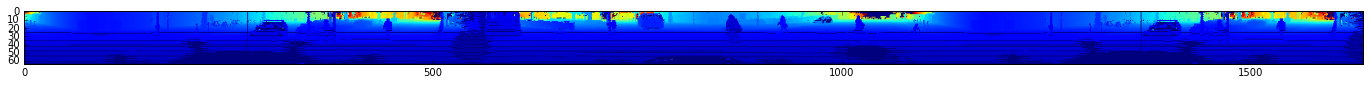

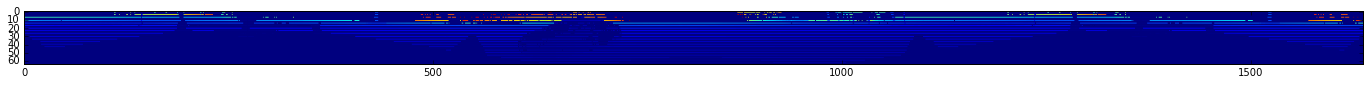

In [4]:
view_kitti = cylindrical_projection_for_test_ver2(lidar_kitti)
fig, ax = plt.subplots(1,1, figsize = (24,3) )
ax.imshow(view_kitti[:,:,5])

view_test = cylindrical_projection_for_test_ver2(lidar_test)
fig, ax = plt.subplots(1,1, figsize = (24,3) )
ax.imshow(view_test[:,:,5])

### Full view detection

Function `predict_boxes_ver3()` divides the panoramic view into `num_views` parts (default value is 4), runs the predictor on each part, then combine all the results 

In [5]:
all_boxes, cluster_boxes = predict_boxes_ver3(model,lidar_kitti, num_views = 4, cluster = True, 
                                              seg_thres=0.5, cluster_dist = 0.2, min_dist = 2, neigbor_thres = 5)
n_boxes = len(all_boxes)
print('Number of predited boxes: {}'.format(n_boxes))
print('Number of boxes after clustering: {}'.format(len(cluster_boxes)))
print('Randomly display 30 boxes then display clustered boxes')
choosen_boxes = np.random.randint(n_boxes, size = 30)
viz_mayavi_with_labels(lidar_kitti, all_boxes[choosen_boxes])
viz_mayavi_with_labels(lidar_kitti, cluster_boxes)

Number of predited boxes: 1819
Number of boxes after clustering: 4
Randomly display 30 boxes then display clustered boxes


### Max interpolation

Let's see how sparse the udacity data comparing to kitti data

In [6]:
d_kitti = view_kitti[:,:,5]
numzero = np.sum(d_kitti==0)
total_pixel = d_kitti.shape[0]*d_kitti.shape[1]
print('For kitti data: ')
print('numzero = {0}, total pixel = {1}, percent of zeros = {2}'.format(numzero,total_pixel, numzero*1./total_pixel))

d_test = view_test[:,:,5]
numzero = np.sum(d_test==0)
total_pixel = d_test.shape[0]*d_test.shape[1]
print('For udacity data: ')
print('numzero = {0}, total pixel = {1}, percent of zeros = {2}'.format(numzero,total_pixel, numzero*1./total_pixel))

For kitti data: 
numzero = 22092, total pixel = 104832, percent of zeros = 0.210737179487
For udacity data: 
numzero = 87875, total pixel = 104832, percent of zeros = 0.838245955433


Function `max_interpolation()` increases the density of panoramic view

In [7]:
view_inter = max_interpolation(view_test, num_points=9)
d_inter = view_inter[:,:,5]
numzero = np.sum(d_inter==0)
total_pixel = d_inter.shape[0]*d_inter.shape[1]
print('After using max interpolation, the density of udacity data:')
print('numzero = {0}, total pixel = {1}, percent of zeros = {2}'.format(numzero,total_pixel, numzero*1./total_pixel))

After using max interpolation, the density of udacity data:
numzero = 47433, total pixel = 104832, percent of zeros = 0.452466804029


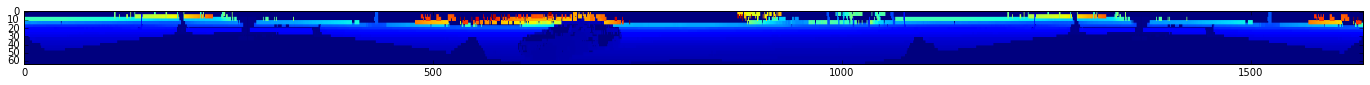

In [8]:
fig, ax = plt.subplots(1,1, figsize = (24,3) )
ax.imshow(view_inter[:,:,5])

### Run predictor after max interpolation

Function `predict_boxes_view()` works similarly as `predict_boxes_ver3()` except instead of lidar points, its input is panoramic view  

In [11]:
all_boxes, cluster_boxes = predict_boxes_view(model,view_inter, cluster = True,
                                         seg_thres=0.1, cluster_dist = 0.5,min_dist = 2, neigbor_thres = 2)
print(len(all_boxes))
print(len(cluster_boxes))

#viz_mayavi_with_labels(lidar_test, all_boxes)
viz_mayavi_with_labels(lidar_test, cluster_boxes)

173
9
